In [136]:
import numpy as np
import json
from matplotlib import pyplot as plt
import os
import Hamiltonians.helper as helper
import Hamiltonians.hamiltonians as ham
from sklearn.cluster import DBSCAN

plt.rcParams['figure.dpi'] = 150
system = "linear_4"
keys = ["run"+str(i) for i in range(1,2)]
colors = ["steelblue","g","gray"]
n_points = 0
for i in range(len(keys)):
    dir_path = keys[i] +"/results"
    n_points += len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
data = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}

In [137]:
data

{'mix_energy': [],
 'mix_shots': [],
 'mix_moments': [],
 'qwc_energy': [],
 'qwc_shots': [],
 'qwc_moments': [],
 'cs_energy': [],
 'cs_shots': [],
 'cs_moments': []}

<h1> Step 1) Collect and Organize Results </h1>

In [138]:
with open("saved_hamiltonians/linear_4_1.json") as fp:
    k = json.load(fp)
ham_qm = ham.Hamiltonian(list(k.keys()), [complex(s) for s in list(k.values())])

In [139]:
ham_mat = ham_qm.to_matrix()

In [140]:
n_points

120

In [141]:
for j in range(len(keys)):
    dir_path = keys[j] +"/results"
    nps = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
    for i in range(nps):
        with open(dir_path+"/"+str(i)+".json") as fp:
            dat_ = json.load(fp)
            for key in data:
                data[key] += [dat_[key]]

In [142]:
for key in data:
    data[key] = np.array(data[key]).T

**Remove Outliers Using DBSCAN Protocol ($\epsilon = 5$, $minsamples = 5$)**

In [143]:
data["mix_energy"].shape

(5, 120)

In [144]:
ks = [1,2,3,4,5]
data_no_outliers = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}
data_no_outliers_save = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}
for key in ["mix_energy", "cs_energy","qwc_energy"]:
    data_no_outliers[key] = [0]*len(ks)
    data_no_outliers_save[key] = [0]*len(ks)
    for i in range(len(ks)):
        X = np.array(data[key][i]).reshape(-1,1)
        clustering = DBSCAN(eps=5, min_samples=5).fit(X)
        clustering.labels_
        Y = np.array([np.inf]*len(X))
        indeces = np.where(clustering.labels_ != -1)[0]
        Y[indeces] = X[indeces].reshape(1,-1)[0]

        data_no_outliers[key][i] = X[indeces].reshape(1,-1)[0]
        data_no_outliers_save[key][i] = Y

In [145]:
import pandas as pd

row_names = {"system":[], "method":[], "shots":[], "computer":[]}
for i in range(ks[-1]*2):
    row_names["Moment " + str(i)] = []
for k in ks:
    row_names["PDS " + str(k)] = []
df = pd.DataFrame(row_names)
print(df)
from tqdm import tqdm
for key_ in ["mix", "qwc", "cs"]:
    for i in tqdm(range(n_points)):
        row = [system, key_,data[key_+"_shots"][i],"qasm simulator"]
        for j in range(ks[-1]*2):
            row += [complex(data[key_+"_moments"][j][i]).real]
        for k in range(len(ks)):
            row += [complex(data[key_+"_energy"][k][i]).real]
        df.loc[len(df.index)] = row
print(df)
df.to_csv('results.csv', index=False)


Empty DataFrame
Columns: [system, method, shots, computer, Moment 0, Moment 1, Moment 2, Moment 3, Moment 4, Moment 5, Moment 6, Moment 7, Moment 8, Moment 9, PDS 1, PDS 2, PDS 3, PDS 4, PDS 5]
Index: []


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 209.47it/s]

       system method  shots        computer  Moment 0  Moment 1  Moment 2  \
0    linear_4    mix  21504  qasm simulator       1.0  1.824219  6.937500   
1    linear_4    mix  21504  qasm simulator       1.0  1.791016  6.566406   
2    linear_4    mix  21504  qasm simulator       1.0  1.748047  6.613281   
3    linear_4    mix  21504  qasm simulator       1.0  1.919922  7.144531   
4    linear_4    mix  21504  qasm simulator       1.0  1.839844  6.785156   
..        ...    ...    ...             ...       ...       ...       ...   
355  linear_4     cs  21465  qasm simulator       1.0  1.836178  7.390245   
356  linear_4     cs  21465  qasm simulator       1.0  1.711569  7.602219   
357  linear_4     cs  21465  qasm simulator       1.0  1.928904  6.761683   
358  linear_4     cs  21465  qasm simulator       1.0  1.836486  7.228454   
359  linear_4     cs  21465  qasm simulator       1.0  1.800582  6.690278   

      Moment 3    Moment 4    Moment 5     Moment 6      Moment 7  \
0     

In [146]:
import pandas as pd
from tqdm import tqdm
row_names = {"system":[], "method":[], "shots":[], "computer":[]}
for k in ks:
    row_names["PDS " + str(k)] = []
df = pd.DataFrame(row_names)

for key_ in ["mix", "qwc", "cs"]:
    for i in tqdm(range(n_points)):
        row = [system, key_,data[key_+"_shots"][i],"qasm simulator"]
        
        for k in range(len(ks)):
            if(data_no_outliers_save[key_+"_energy"][k][i] == np.inf):
                row += ["X"]
            else:
                row += [data_no_outliers_save[key_+"_energy"][k][i]]
        df.loc[len(df.index)] = row
print(df)
df.to_csv('results_no_outliers.csv', index=False)


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 243.19it/s]


       system method  shots        computer     PDS 1     PDS 2     PDS 3  \
0    linear_4    mix  21504  qasm simulator  1.824219 -3.280057 -5.849605   
1    linear_4    mix  21504  qasm simulator  1.791016 -3.019746 -5.797356   
2    linear_4    mix  21504  qasm simulator  1.748047 -2.964127 -5.305573   
3    linear_4    mix  21504  qasm simulator  1.919922 -3.419333 -5.675829   
4    linear_4    mix  21504  qasm simulator  1.839844 -3.002483 -5.360181   
..        ...    ...    ...             ...       ...       ...       ...   
355  linear_4     cs  21465  qasm simulator  1.836178 -3.828922  -5.65329   
356  linear_4     cs  21465  qasm simulator  1.711569 -4.270059  -6.13839   
357  linear_4     cs  21465  qasm simulator  1.928904 -2.698075 -5.070638   
358  linear_4     cs  21465  qasm simulator  1.836486 -3.825469 -6.059047   
359  linear_4     cs  21465  qasm simulator  1.800582 -2.606357 -4.443967   

        PDS 4     PDS 5  
0   -6.353467 -6.458568  
1   -6.327974 -6.456623

In [147]:
data_no_outliers_save

{'mix_energy': [array([1.82421875, 1.79101562, 1.74804688, 1.91992188, 1.83984375,
         1.84375   , 1.7578125 , 1.82421875, 1.94335938, 1.77734375,
         1.828125  , 1.6484375 , 1.87109375, 1.83007812, 1.91796875,
         1.81835938, 1.78515625, 1.7109375 , 1.83203125, 1.84960938,
         1.89648438, 1.7421875 , 1.75      , 1.89648438, 1.92773438,
         1.87695312, 1.671875  , 1.734375  , 1.80078125, 1.67773438,
         1.8671875 , 1.93945312, 1.83789062, 1.84765625, 1.71875   ,
         1.75976562, 1.8203125 , 1.81835938, 1.88085938, 1.84570312,
         1.81054688, 1.74023438, 1.8203125 , 1.88085938, 1.671875  ,
         1.80078125, 1.78515625, 1.95117188, 1.69335938, 1.86328125,
         1.9140625 , 1.65039062, 1.89257812, 1.95117188, 1.85742188,
         1.81445312, 1.86328125, 1.7734375 , 1.97851562, 1.88085938,
         1.75      , 1.9375    , 1.90429688, 1.77734375, 1.8125    ,
         1.83398438, 1.89648438, 1.78320312, 1.76953125, 1.76171875,
         1.82226562,

<h1> Step 2) Visualize Data </h1>

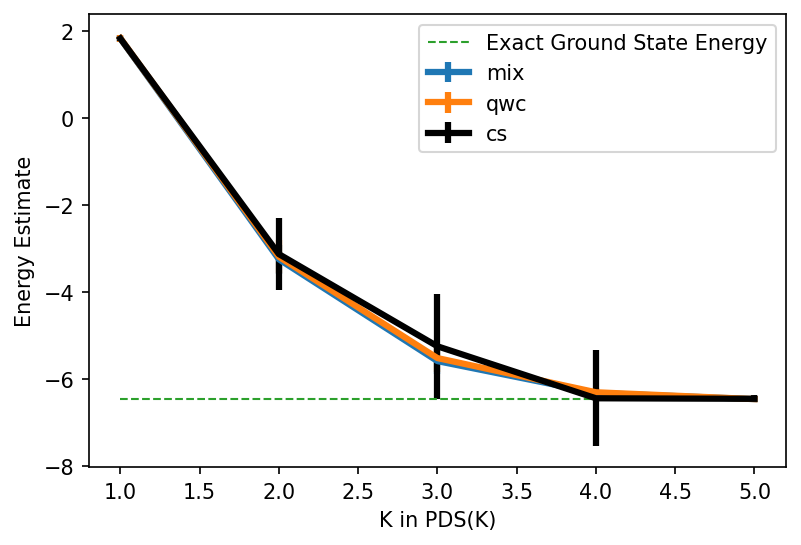

In [148]:
plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], lw =3, label="mix")
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], lw =3, label="qwc")
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], lw = 3, color="black", label="cs")
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.plot(ks,[min_e]*len(ks),lw = 1, linestyle="dashed", label="Exact Ground State Energy")
plt.legend()
plt.xlabel("K in PDS(K)")
plt.ylabel("Energy Estimate")
plt.savefig("figures/energy_"+system+".jpg")

Looks pretty good! A prettier version of the plot will follow.

(21511.8, 0)


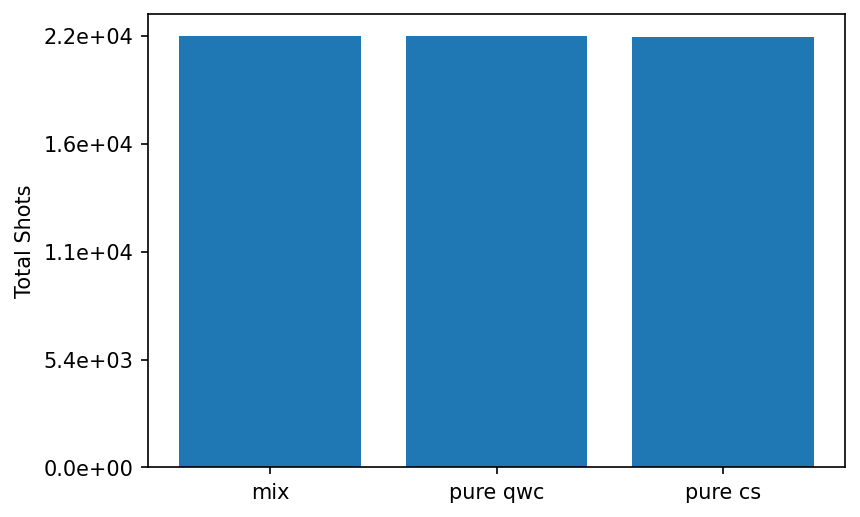

In [149]:
plt.bar(["mix","pure qwc","pure cs"],[data["mix_shots"].mean(), data["qwc_shots"].mean(), data["cs_shots"].mean()])
def get_ticks_shots(data_, p=35, n_ticks=5):
    # helper function to scale y-axis nicely
    max_ = -1000
    d1 = [np.mean(data_["mix_shots"][i]) for i in range(len(ks))] 
    d2 = [np.mean(data_["qwc_shots"][i]) for i in range(len(ks))]
    d3 = [np.mean(data_["cs_shots"][i]) for i in range(len(ks))] 
    max_ = max(max(d1), max(d2), max(d3))
    min_ = min(min(d1), min(d2), min(d3))
    bounds = (max_ + (0.01 * p) * (max_-min_), 0)
    print(bounds)
    ticks = np.linspace(bounds[0], bounds[1], n_ticks+2)
    return ticks
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

sticks = get_ticks_shots(data,20,3)
plt.yticks(sticks)
plt.ylabel("Total Shots")
plt.savefig("figures/shots_"+system+".jpg")

**Set up analytical version of the system to calculate exact PDS(K) for comparison to moment mixing scheme**

In [150]:
n_qubits = 4
K = 5
ket0 = np.array([1.,0.],dtype=complex)
ket1 = np.array([0.,1.],dtype=complex)


PauliX = np.array([[0.,1.],[1.,0]], dtype=complex)
PauliY = np.array([[0.,-1.j],[1.j,0]], dtype=complex)
PauliZ = np.array([[1.0,0.],[0.,-1.]], dtype=complex)
PauliI = np.eye(2, dtype=complex)
PauliVec = [PauliX, PauliY, PauliZ]
cz = np.eye(4)
cz[3,3] = -1
PauliDict = {"Identity": "I", "PauliX": "X", "PauliY": "Y", "PauliZ": "Z"}
PauliNumToLetter = {0: "X", 1: "Y", 2: "Z"}
PauliDict_2 = {"I": PauliI, "X": PauliX, "Y": PauliY, "Z": PauliZ}
Hadamard = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]])
CNOT = np.eye(4)
CNOT[3,3]=0
CNOT[2,2] = 0 
CNOT[3,2] = 1
CNOT[2,3] = 1
thetaTest = [-2,1]
cz = np.eye(4)
cz[3,3] = -1


"""

====================
FUNCTION DEFINITIONS
++++++++++++++++++++


"""

def RY(theta):
    '''
        matrix representation of the RY gate in the Z computational basis
    '''
    matrix = np.zeros((2,2),dtype=complex)
    matrix[0,0] = np.cos(theta/2)
    matrix[1,1] = np.cos(theta/2)
    matrix[0,1] = -np.sin(theta/2)
    matrix[1,0] =  np.sin(theta/2)
    return matrix
def RZ(theta):
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0,0] = np.exp(-1.j * theta/2)
    matrix[1,1] = np.exp(1.j * theta/2)
    return matrix
def linear_hamiltonian_matrix_dict(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = {}
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = ["I" for i in range(n)]
            A[i] = PauliNumToLetter[k]
            A[next_] = PauliNumToLetter[k]
            x = j
            if(k==2):
                x = u
            H["".join(A)] = x
    return H

def linear_hamiltonian_matrix(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = [PauliI for i in range(n)]
            A[i] = PauliVec[k]
            A[next_] = PauliVec[k]
            x = j
            if(k==2):
                x = u
            add = [1]
            for qbit in range(n):
                
                add = np.kron(add, A[qbit])
            H += x*add
    return H

def circuit(theta):
    qc = qm.QuantumCircuit(n_qubits,n_qubits)
    for w in range(n_qubits-1):
        qc.h(w)
        qc.ry(theta[w], w)
    for w in range(n_qubits-1):
        qc.cnot(w, w+1)
    for w in range(n_qubits):
        qc.rz(theta[w + n_qubits], w)
    return qc

def circuit_numerical(theta):
    psi = np.zeros(2 ** n_qubits)
    print(2**n_qubits)
    psi[0] = 1 # initialize in |0000....000>
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, Hadamard)
        psi = obs_ @ psi 
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RY(theta[w]))
        psi = obs_ @ psi 
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w and not i == w+1:
                obs_ = np.kron(obs_, PauliI)
            elif i == w:
                obs_ = np.kron(obs_, CNOT)
            elif i == w+1:
                pass;
            
        psi = obs_ @ psi
    for w in range(n_qubits):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RZ(theta[w+n_qubits]))
        psi = obs_ @ psi
    return psi



def tildeM(e_dict, K):
    M = np.zeros((K,K), dtype=complex)
    for i in range(1,K+1):
        for j in range(1,K+1):
            M[i-1,j-1] = e_dict[int(2*K-i-j)]
    return M

def tildeY(e_dict, K):
    Y = np.zeros(K, dtype=complex)
    for i in range(1,K+1):
        Y[i-1] = e_dict[int(2*K-i)]
    return Y
def comp_energy(moments, K):
    M_ = tildeM(moments, K)
    Y_ = tildeY(moments, K)
    X_ = np.linalg.lstsq(M_, -Y_,rcond=None)[0]
    coeffs = np.ones(K+1)
    for k in range(1,K+1):
        coeffs[k] = X_[k-1].real
    return np.min(np.roots(coeffs)).real

In [151]:
theta_test = np.genfromtxt(keys[0]+"/theta_4_save.txt") # load the rotation used to prepare the ansatz
                                                        # all rotations for each run is are the same
                                                        # here we use the first run, however it shouldn't matter
psi_numerical = circuit_numerical(theta_test)

16


In [152]:
exps = {}
for i in range(2*K):
    with open("saved_hamiltonians/linear_4_"+str(i)+".json") as fp:
        k = json.load(fp)
        for key in k:
            if key not in exps:
                exps[key] = np.conjugate(psi_numerical).T @ ham.Hamiltonian([key],[1]).to_matrix() @ psi_numerical

In [153]:
exps

{'IIII': (0.9999999999999992+0j),
 'XXII': (-0.3732131224640195+0j),
 'YYII': (0.40701459777897087+0j),
 'ZZII': (0.8554624934993634+0j),
 'IXXI': 0j,
 'IYYI': 0j,
 'IZZI': (-0.054724575342061293+0j),
 'IIXX': (-0.5634245512236737+0j),
 'IIYY': (0.5634245512236737+0j),
 'IIZZ': (0.9999999999999992+0j),
 'XIXI': 0j,
 'XXXX': (0.22057254894344375+1.3877787807814457e-17j),
 'XXYY': (-0.22057254894344375-1.3877787807814457e-17j),
 'XXZZ': (-0.3732131224640195+0j),
 'YIYI': 0j,
 'YYXX': (-0.23704458001345402+0j),
 'YYYY': (0.23704458001345402+0j),
 'YYZZ': (0.40701459777897087+0j),
 'ZIZI': (-0.04681482167781359+0j),
 'ZZXX': (-0.4819885714885641+0j),
 'ZZYY': (0.4819885714885641+0j),
 'ZZZZ': (0.8554624934993634+0j),
 'IXIX': 0j,
 'IYIY': 0j,
 'IZIZ': (-0.054724575342061293+0j),
 'XIIX': 0j,
 'XZZX': 0j,
 'XYYX': (0.18812595335855475-3.469446951953614e-18j),
 'XYXY': (0.18812595335855475-3.469446951953614e-18j),
 'XZXZ': 0j,
 'YIIY': 0j,
 'YXYX': (0.14111690899531865+6.938893903907228e-18j

In [120]:
with open ("sample_expectations/mix_run_0.json") as fp:
    mix_exps = json.load(fp)

In [154]:

def lettersToNums(l):
    # some simple helper func to convert the pauli strings
    # into the form that the shadows use
    numsL = []
    for i in l:
        if(i == "X"):
            numsL += [0]
        elif(i == "Y"):
            numsL += [1]
        elif(i == "Z"):
            numsL += [2]
        else:
            numsL += [3]
    return numsL


In [155]:
def estimate_shadow_observable_fast(shadow, target_obs, k=10):
    '''Estimate the expectation value of an observabley,
    with k median of means chunks'''
    means = []
    snap, obs = shadow
    chunk_size = len(snap) // k
    pauli_locations = [i for i in range(len(target_obs)) if target_obs[i] != 3]
    tobs = target_obs[pauli_locations]
    snap2 = snap[:,pauli_locations]
    obs2 = obs[:,pauli_locations]
    nper = int(np.floor(len(obs) / k))
    num_per_max = [nper] * k
    num_per_max[-1] = len(snap) - nper * (k - 1)
    for i in range(k):
        snap_chunk, obs_chunk = (
            snap2[i * nper : i *nper + num_per_max[i]],
            obs2[i * nper : i *nper + num_per_max[i]],
        )
        indices = np.all(obs_chunk == tobs, axis=1)
        if sum(indices) > 0:
            means += [np.sum(np.prod(snap_chunk[indices], axis=1))/sum(indices)]
        else:
            means += [0]
    return np.median(means)

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


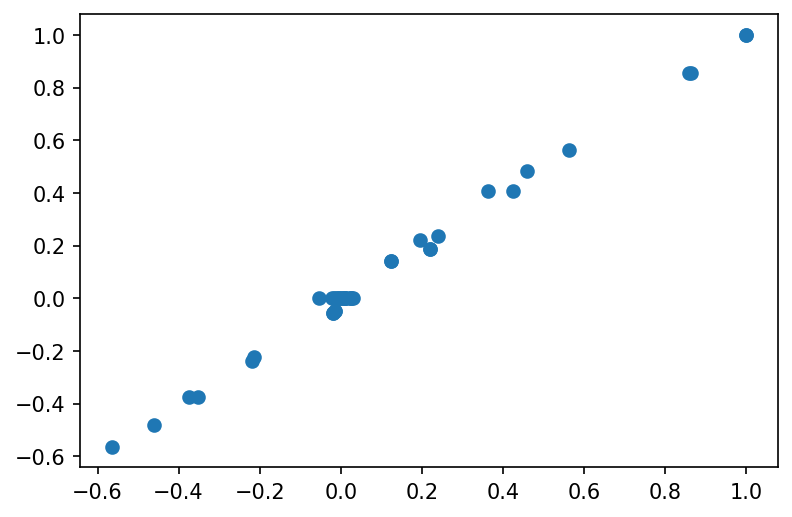

In [156]:
exps = {key: exps[key] for key in mix_exps}
plt.scatter(mix_exps.values(), exps.values())

In [157]:
moments = {i: np.conjugate(psi_numerical).T @ np.linalg.matrix_power(ham_qm.to_matrix(), i) @ psi_numerical for i in range(0,15)}

In [158]:
print("Exact Moments:")
print(moments)

Exact Moments:
{0: (0.9999999999999992+0j), 1: (1.834539393472253+1.1102230246251565e-16j), 2: (6.906370356644367-4.440892098500626e-16j), 3: (10.198326596526407+0j), 4: (82.96376489988322+0j), 5: (-60.75419303790294+0j), 6: (1659.2518551397443-1.4210854715202004e-14j), 7: (-6403.974326895098+0j), 8: (52199.70294360146-2.7284841053187847e-12j), 9: (-297038.7342452046+0j), 10: (2010171.9956264729+5.820766091346741e-11j), 11: (-12605743.085313888+2.3283064365386963e-10j), 12: (82196009.85637514-1.862645149230957e-09j), 13: (-527457140.50259906+0j), 14: (3414495976.7540355+0j)}


In [159]:
def moment(n, e_dict_, ham_):
    e = 0
    for i in range(len(ham_.letters)):
        e += ham_.coeffs[i] * e_dict_[ham_.letters[i]]
    return e

In [160]:
ks = [i for i in range(1, K+1)]
es = []
for k in ks:
    es += [comp_energy(moments, k)]

In [161]:
exact_pds = es
print(exact_pds)

[1.8345393934722545, -3.2315224148889676, -5.572883896037126, -6.320518095875549, -6.459961996640277]


**Calculate errors for moment mix runs**

In [162]:
errors = {}
errors["mix_energy"] = [0]*len(ks)
errors["cs_energy"] = [0]*len(ks)
errors["qwc_energy"] = [0]*len(ks)
for j in range(len(ks)):
    errors["mix_energy"][j] = np.abs(np.array(data_no_outliers["mix_energy"][j])-exact_pds[j])
    errors["cs_energy"][j] = np.abs(np.array(data_no_outliers["cs_energy"][j])-exact_pds[j])
    errors["qwc_energy"][j] = np.abs(np.array(data_no_outliers["qwc_energy"][j])-exact_pds[j])


In [163]:
def get_ticks(data_, p=35, n_ticks=5):
    max_ = -1000
    d1 = [np.mean(data_["mix_energy"][i]) for i in range(len(ks))] 
    d2 = [np.mean(data_["qwc_energy"][i]) for i in range(len(ks))]
    d3 = [np.mean(data_["cs_energy"][i]) for i in range(len(ks))] 
    max_ = max(max(d1), max(d2), max(d3))
    min_ = min(min(d1), min(d2), min(d3))
    bounds = (max_ + (0.01 * p) * (max_-min_), min_ - (0.01 * p) * (max_-min_))
    print(bounds)
    ticks = np.linspace(bounds[0], bounds[1], n_ticks+2)
    return ticks

In [164]:
ticks = get_ticks(data_no_outliers)
eticks = get_ticks(errors, 130)
print(eticks)

(4.735850863482187, -9.362565756169388)
(1.843259830576984, -1.0366457613102584)
[ 1.84325983  1.36327557  0.8832913   0.40330703 -0.07667723 -0.5566615
 -1.03664576]


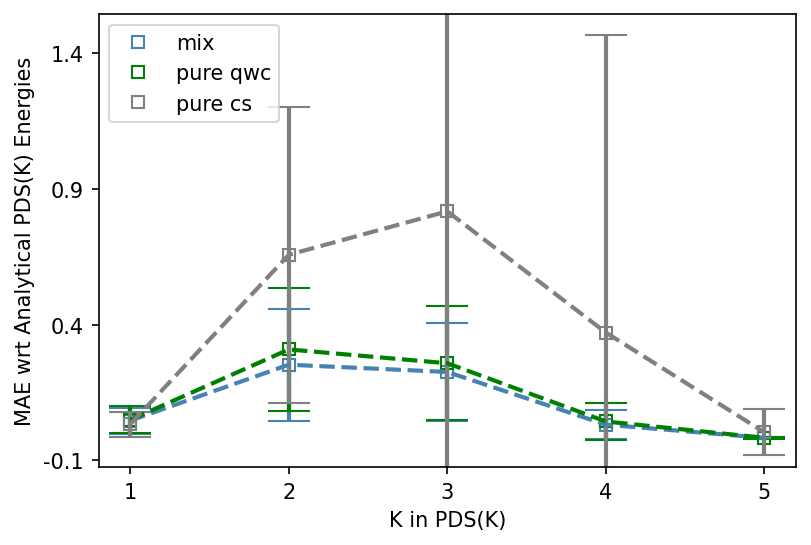

In [165]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter
fig, ax1 = plt.subplots()
ax1.errorbar(ks, [np.mean(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[0])
ax1.plot(ks, [np.mean(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[0],linestyle="none",fillstyle='none',label="mix")
ax1.errorbar(ks, [np.mean(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[1])
ax1.plot(ks, [np.mean(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[1],linestyle="none",fillstyle='none',label="pure qwc")
ax1.errorbar(ks, [np.mean(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[2])
ax1.plot(ks, [np.mean(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[2],linestyle="none",fillstyle='none',label="pure cs")
ax1.set_xticks([1,2,3,4,5])
ax1.set_yticks(eticks[1:-1])
ax1.set_ylim((-0.1, 1.5))
ax1.legend(loc="upper left")
ax1.set_ylabel("MAE wrt Analytical PDS(K) Energies")
ax1.set_xlabel("K in PDS(K)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.savefig("figures/mae_pretty_"+system+".jpg")

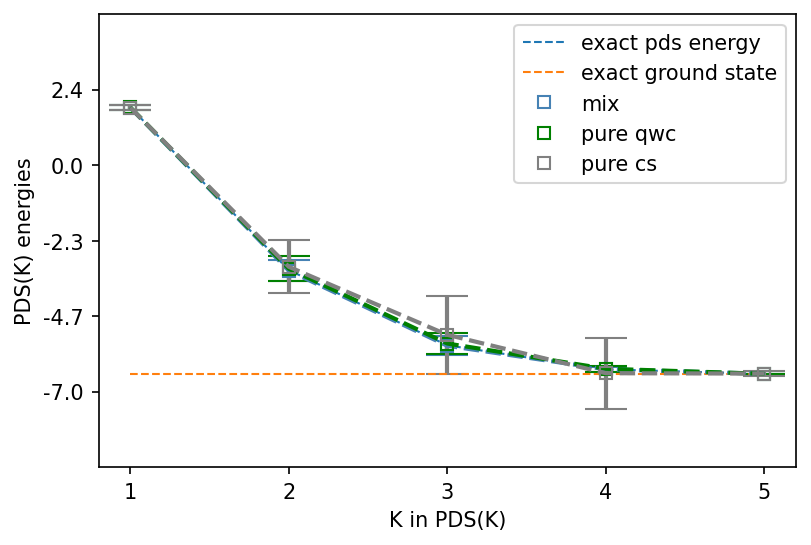

In [166]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter

plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[0])
plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="mix", color=colors[0])
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[1])
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure qwc", color=colors[1])
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[2])
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure cs", color=colors[2])
plt.plot(ks,exact_pds,lw = 1, linestyle="dashed", label="exact pds energy")
plt.plot(ks,[min_e]*len(ks),lw = 1, linestyle="dashed", label="exact ground state")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((ticks[-1], ticks[0]))
plt.xlabel("K in PDS(K)")
plt.ylabel("PDS(K) energies")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.yticks(ticks[1:-1])
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.savefig("figures/energy_pretty_"+system+".jpg")

** some extra code to analyze the moment estimations for each method

[[0.05564057 0.22561913 0.20447288 0.04039449 0.00265712]
 [0.07245118 0.29761352 0.26741151 0.05928145 0.00398318]]


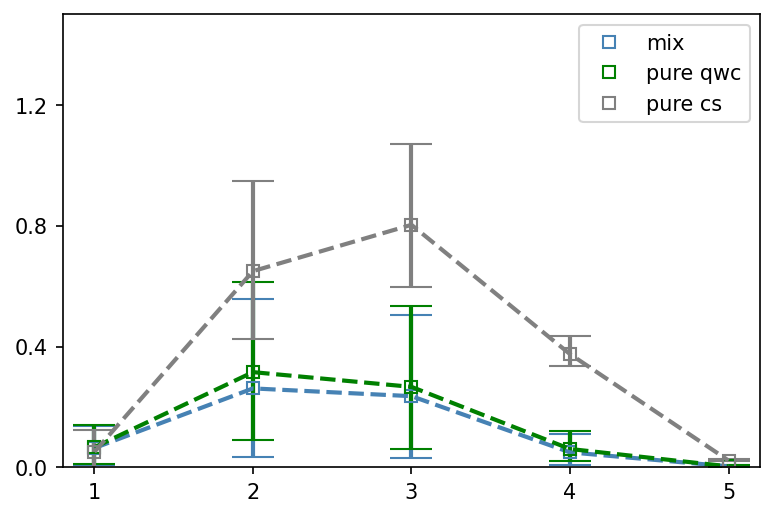

In [170]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as st
confidence_intervals = []
for i in range(len(ks)):
    e_data = errors["mix_energy"][i]
    c = st.t.interval(alpha=0.95, df=len(e_data)-1, loc=np.mean(e_data), scale=st.sem(e_data)) 
    confidence_intervals += [c]
confidence_intervals = np.array(confidence_intervals).T
print(confidence_intervals)

plt.errorbar(ks, [np.mean(errors["mix_energy"][i]) for i in range(len(ks))], 
             yerr=confidence_intervals, lw =2, ls="dashed", capsize=10, color=colors[0])
plt.errorbar(ks, [np.mean(errors["mix_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="mix", color=colors[0])

confidence_intervals = []
for i in range(len(ks)):
    e_data = errors["mix_energy"][i]
    c = st.t.interval(alpha=0.95, df=len(e_data)-1, loc=np.mean(e_data), scale=st.sem(e_data)) 
    confidence_intervals += [c]
confidence_intervals = np.array(confidence_intervals).T
plt.errorbar(ks, [np.mean(errors["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=confidence_intervals, lw =2, ls="dashed", capsize=10, color=colors[1])
plt.errorbar(ks, [np.mean(errors["qwc_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure qwc", color=colors[1])

confidence_intervals = []
for i in range(len(ks)):
    e_data = errors["mix_energy"][i]
    c = st.t.interval(alpha=0.95, df=len(e_data)-1, loc=np.mean(e_data), scale=st.sem(e_data)) 
    confidence_intervals += [c]
confidence_intervals = np.array(confidence_intervals).T
    
plt.errorbar(ks, [np.mean(errors["cs_energy"][i]) for i in range(len(ks))], 
             yerr=confidence_intervals, lw =2, ls="dashed", capsize=10, color=colors[2])
plt.errorbar(ks, [np.mean(errors["cs_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure cs", color=colors[2])
plt.legend()
plt.xticks([1,2,3,4,5])
plt.yticks([0,0.4,0.8,1.2])
plt.ylim((0, 1.5))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.savefig("figures/mae_confidence_intervals_"+system+".jpg")

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[0, 0.0, (1+0j), (1+0j)]


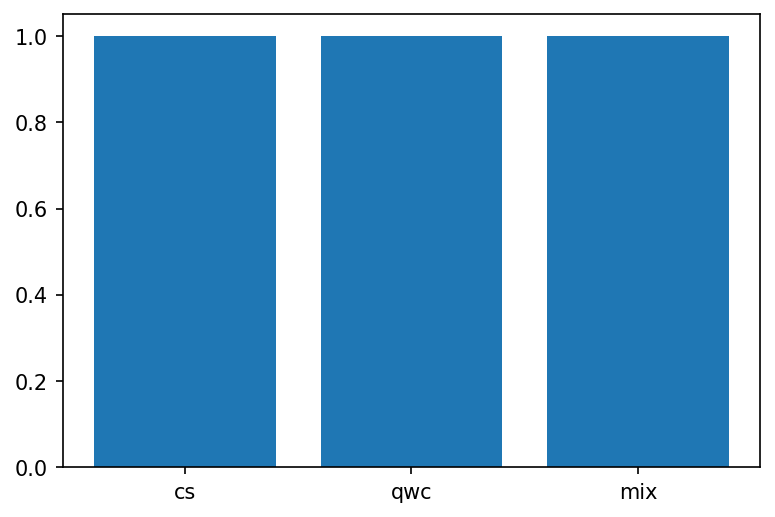

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[1, 0.0600034273812144, (1.8391335227272727+0j), (1.8188032670454546+0j)]


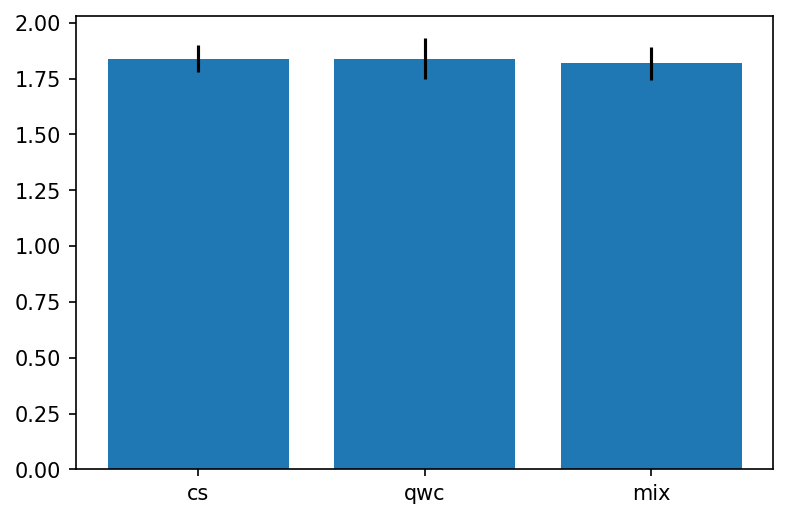

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[2, 0.47042204458630066, (6.856001420454546+0j), (6.932173295454546+0j)]


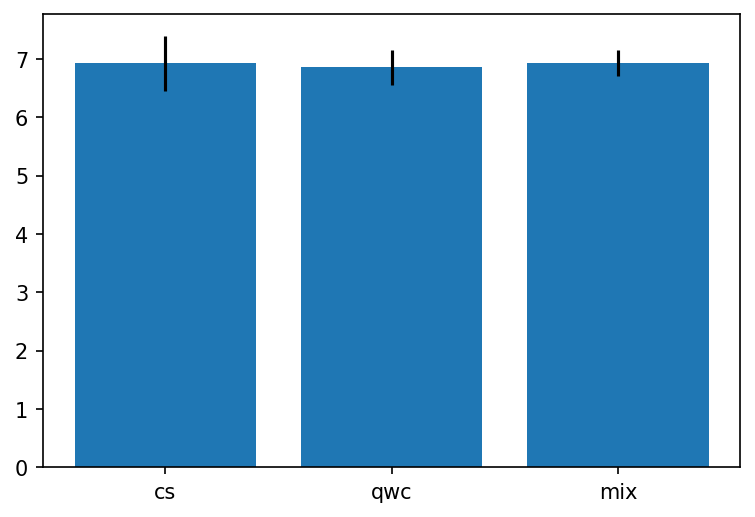

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[3, 2.7222060130069554, (10.512251420454545+0j), (9.841530539772728+0j)]


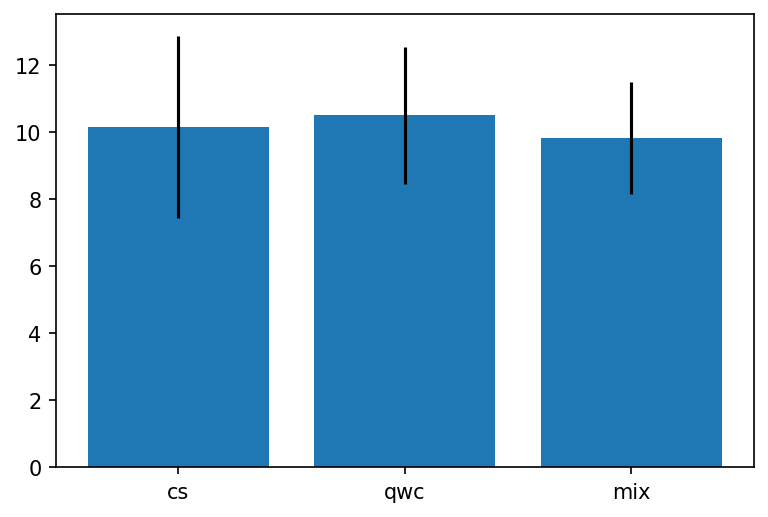

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[4, 20.13151445359609, (80.6807528409091+0j), (84.21519886363636+0j)]


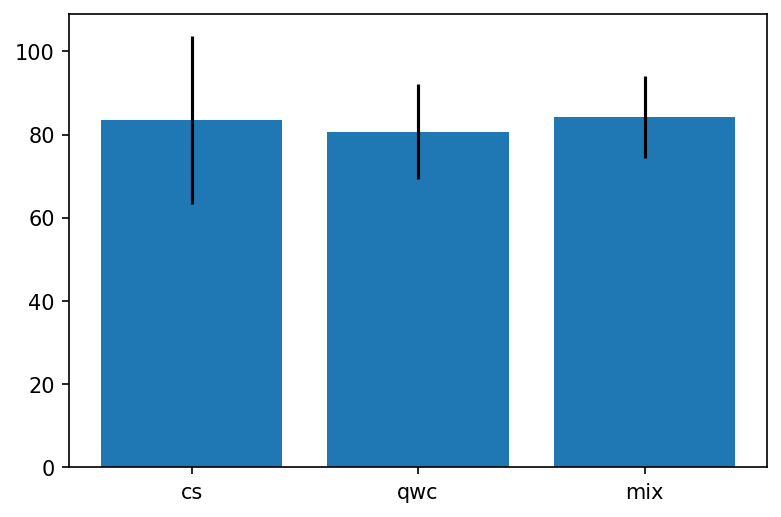

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[5, 129.73720311506563, (-46.23934659090909+0j), (-70.4979580965909+0j)]


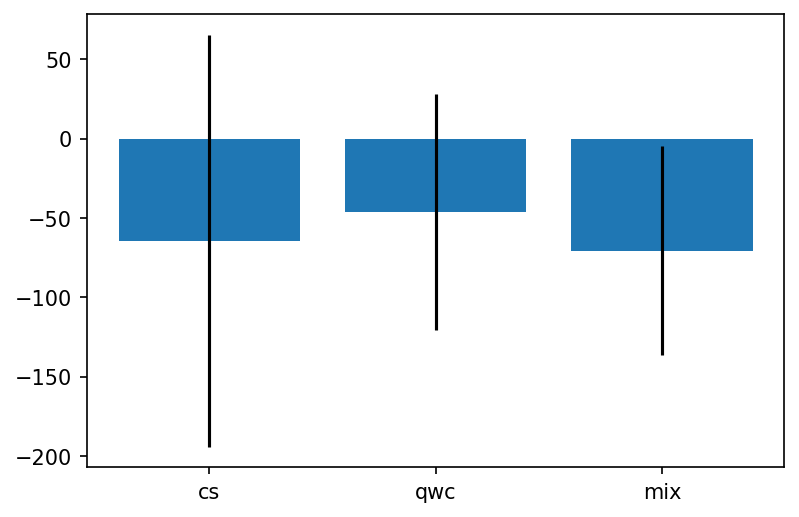

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[6, 871.1855669165515, (1562.3322088068182+0j), (1710.61328125+0j)]


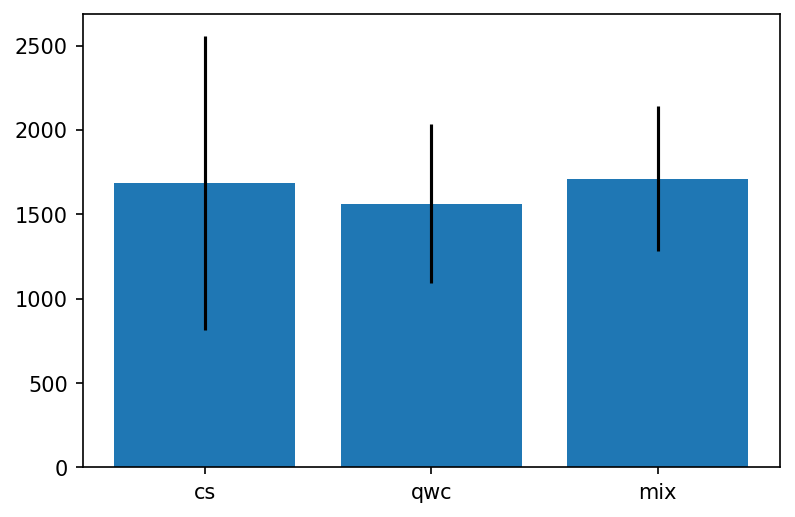

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[7, 5661.62986832162, (-5778.631569602273+0j), (-6746.696821732955+0j)]


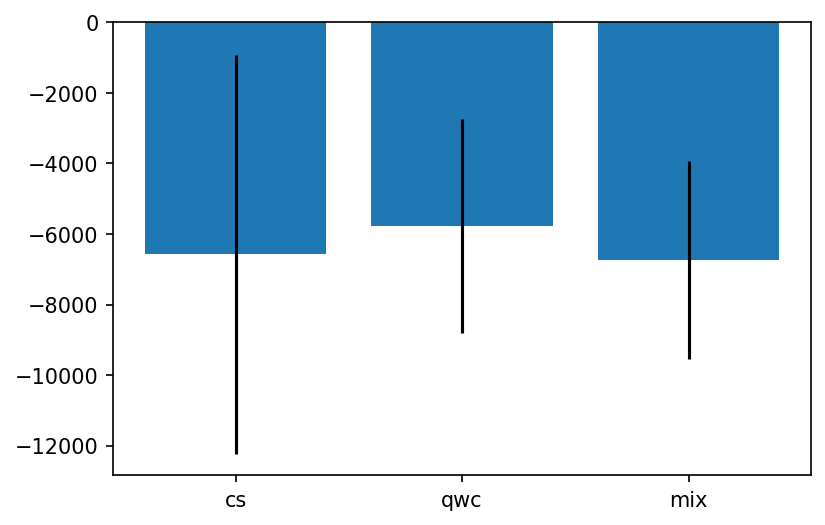

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[8, 37013.88676153321, (48121.361505681816+0j), (54287.765625+0j)]


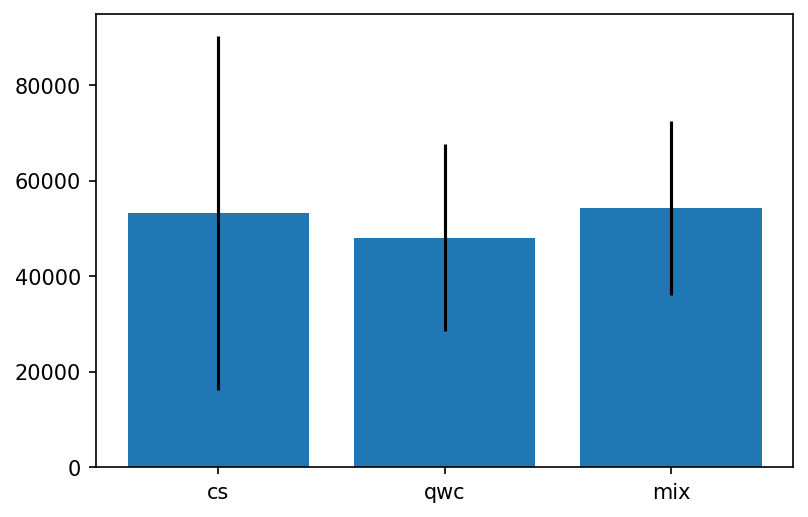

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[9, 239991.26655632976, (-270662.25532670453+0j), (-310558.49085582385+0j)]


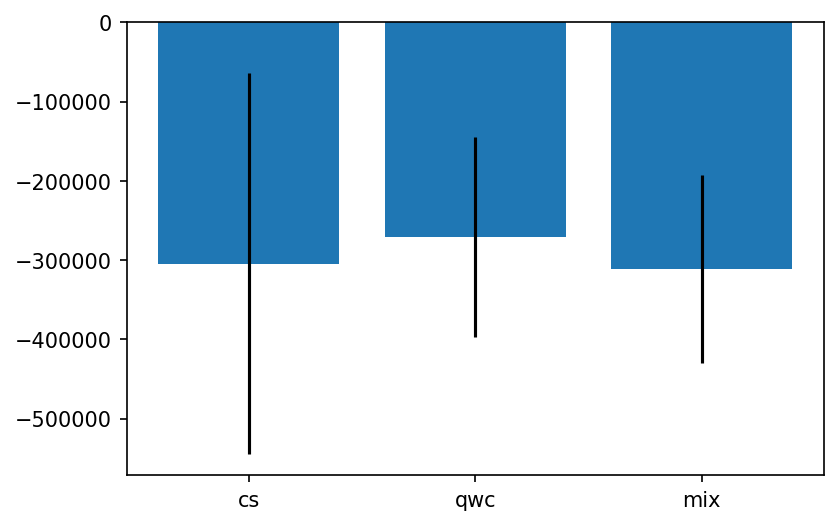

[ 1.00000000e+00+0.j  1.87559429e+00+0.j  6.26703583e+00+0.j
  1.28845254e+01+0.j  6.71820126e+01+0.j  2.50805894e+01+0.j
  1.14688301e+03+0.j -3.30035262e+03+0.j  3.28286499e+04+0.j
 -1.74739571e+05+0.j]
[ 1.00000000e+00+0.j  1.88272583e+00+0.j  6.84627575e+00+0.j
  9.79984140e+00+0.j  8.90405720e+01+0.j -1.11275764e+02+0.j
  2.03715761e+03+0.j -9.01504097e+03+0.j  6.98131952e+04+0.j
 -4.13424028e+05+0.j]
[ 1.00000000e+00+0.j  1.83955006e+00+0.j  6.67811041e+00+0.j
  1.22883445e+01+0.j  6.78496321e+01+0.j  4.78199973e+01+0.j
  9.34533585e+02+0.j -1.56697137e+03+0.j  2.05592196e+04+0.j
 -9.04237950e+04+0.j]
[ 1.00000000e+00+0.j  1.78288431e+00+0.j  7.18858954e+00+0.j
  7.34881104e+00+0.j  1.01565456e+02+0.j -1.92960414e+02+0.j
  2.52609724e+03+0.j -1.21545682e+04+0.j  8.96356079e+04+0.j
 -5.40936013e+05+0.j]
[ 1.00000000e+00+0.j  1.81141046e+00+0.j  7.06022187e+00+0.j
  8.54358162e+00+0.j  9.36465927e+01+0.j -1.39773376e+02+0.j
  2.17449604e+03+0.j -9.86034390e+03+0.j  7.46842964e+04+0

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


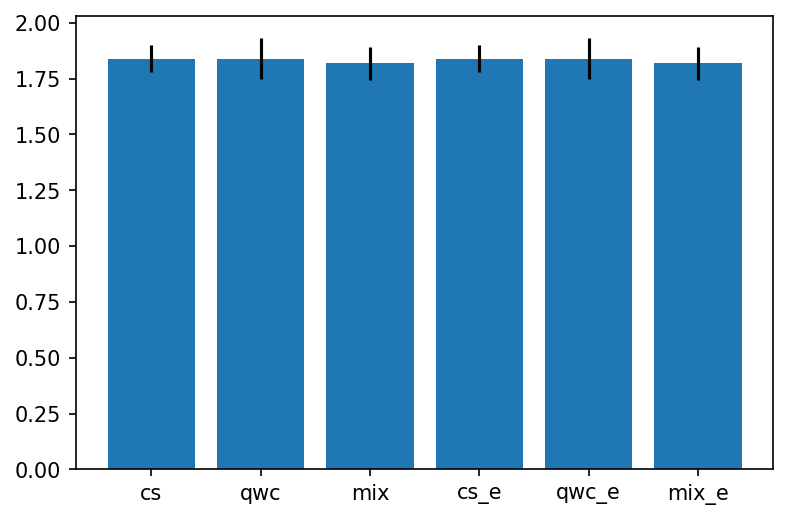

[ 1.00000000e+00+0.j  1.87559429e+00+0.j  6.26703583e+00+0.j
  1.28845254e+01+0.j  6.71820126e+01+0.j  2.50805894e+01+0.j
  1.14688301e+03+0.j -3.30035262e+03+0.j  3.28286499e+04+0.j
 -1.74739571e+05+0.j]
[ 1.00000000e+00+0.j  1.88272583e+00+0.j  6.84627575e+00+0.j
  9.79984140e+00+0.j  8.90405720e+01+0.j -1.11275764e+02+0.j
  2.03715761e+03+0.j -9.01504097e+03+0.j  6.98131952e+04+0.j
 -4.13424028e+05+0.j]
[ 1.00000000e+00+0.j  1.83955006e+00+0.j  6.67811041e+00+0.j
  1.22883445e+01+0.j  6.78496321e+01+0.j  4.78199973e+01+0.j
  9.34533585e+02+0.j -1.56697137e+03+0.j  2.05592196e+04+0.j
 -9.04237950e+04+0.j]
[ 1.00000000e+00+0.j  1.78288431e+00+0.j  7.18858954e+00+0.j
  7.34881104e+00+0.j  1.01565456e+02+0.j -1.92960414e+02+0.j
  2.52609724e+03+0.j -1.21545682e+04+0.j  8.96356079e+04+0.j
 -5.40936013e+05+0.j]
[ 1.00000000e+00+0.j  1.81141046e+00+0.j  7.06022187e+00+0.j
  8.54358162e+00+0.j  9.36465927e+01+0.j -1.39773376e+02+0.j
  2.17449604e+03+0.j -9.86034390e+03+0.j  7.46842964e+04+0

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


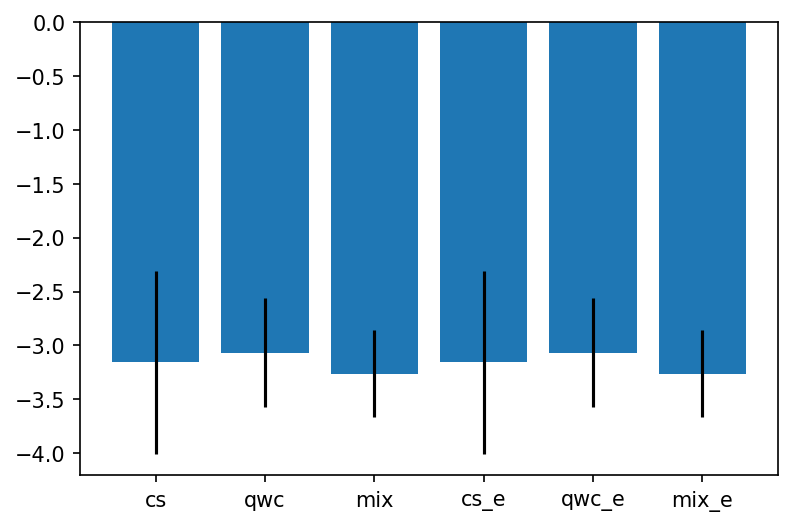

[ 1.00000000e+00+0.j  1.87559429e+00+0.j  6.26703583e+00+0.j
  1.28845254e+01+0.j  6.71820126e+01+0.j  2.50805894e+01+0.j
  1.14688301e+03+0.j -3.30035262e+03+0.j  3.28286499e+04+0.j
 -1.74739571e+05+0.j]
[ 1.00000000e+00+0.j  1.88272583e+00+0.j  6.84627575e+00+0.j
  9.79984140e+00+0.j  8.90405720e+01+0.j -1.11275764e+02+0.j
  2.03715761e+03+0.j -9.01504097e+03+0.j  6.98131952e+04+0.j
 -4.13424028e+05+0.j]
[ 1.00000000e+00+0.j  1.83955006e+00+0.j  6.67811041e+00+0.j
  1.22883445e+01+0.j  6.78496321e+01+0.j  4.78199973e+01+0.j
  9.34533585e+02+0.j -1.56697137e+03+0.j  2.05592196e+04+0.j
 -9.04237950e+04+0.j]
[ 1.00000000e+00+0.j  1.78288431e+00+0.j  7.18858954e+00+0.j
  7.34881104e+00+0.j  1.01565456e+02+0.j -1.92960414e+02+0.j
  2.52609724e+03+0.j -1.21545682e+04+0.j  8.96356079e+04+0.j
 -5.40936013e+05+0.j]
[ 1.00000000e+00+0.j  1.81141046e+00+0.j  7.06022187e+00+0.j
  8.54358162e+00+0.j  9.36465927e+01+0.j -1.39773376e+02+0.j
  2.17449604e+03+0.j -9.86034390e+03+0.j  7.46842964e+04+0

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


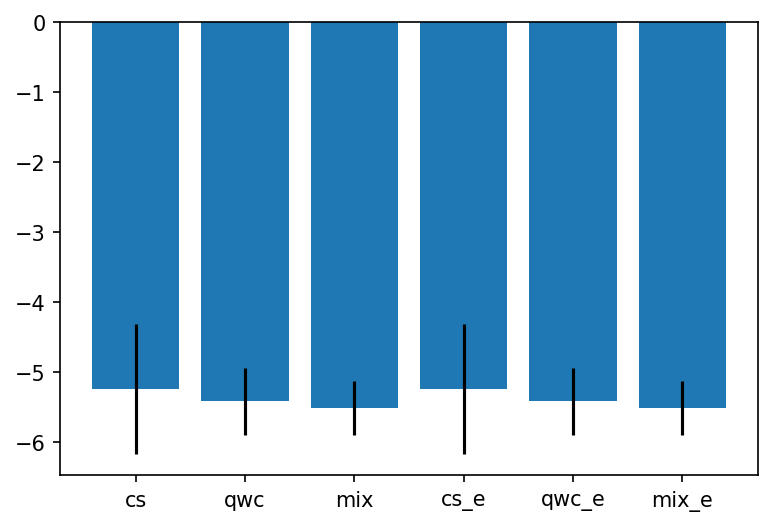

[ 1.00000000e+00+0.j  1.87559429e+00+0.j  6.26703583e+00+0.j
  1.28845254e+01+0.j  6.71820126e+01+0.j  2.50805894e+01+0.j
  1.14688301e+03+0.j -3.30035262e+03+0.j  3.28286499e+04+0.j
 -1.74739571e+05+0.j]
[ 1.00000000e+00+0.j  1.88272583e+00+0.j  6.84627575e+00+0.j
  9.79984140e+00+0.j  8.90405720e+01+0.j -1.11275764e+02+0.j
  2.03715761e+03+0.j -9.01504097e+03+0.j  6.98131952e+04+0.j
 -4.13424028e+05+0.j]
[ 1.00000000e+00+0.j  1.83955006e+00+0.j  6.67811041e+00+0.j
  1.22883445e+01+0.j  6.78496321e+01+0.j  4.78199973e+01+0.j
  9.34533585e+02+0.j -1.56697137e+03+0.j  2.05592196e+04+0.j
 -9.04237950e+04+0.j]
[ 1.00000000e+00+0.j  1.78288431e+00+0.j  7.18858954e+00+0.j
  7.34881104e+00+0.j  1.01565456e+02+0.j -1.92960414e+02+0.j
  2.52609724e+03+0.j -1.21545682e+04+0.j  8.96356079e+04+0.j
 -5.40936013e+05+0.j]
[ 1.00000000e+00+0.j  1.81141046e+00+0.j  7.06022187e+00+0.j
  8.54358162e+00+0.j  9.36465927e+01+0.j -1.39773376e+02+0.j
  2.17449604e+03+0.j -9.86034390e+03+0.j  7.46842964e+04+0

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


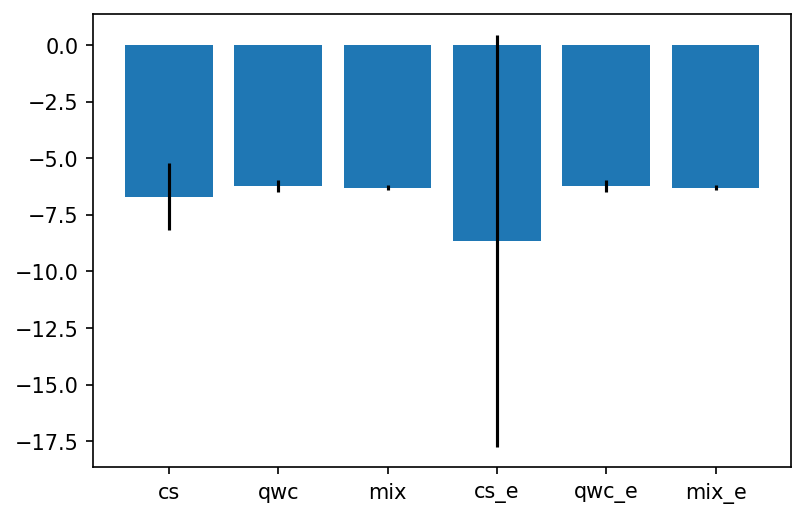

[ 1.00000000e+00+0.j  1.87559429e+00+0.j  6.26703583e+00+0.j
  1.28845254e+01+0.j  6.71820126e+01+0.j  2.50805894e+01+0.j
  1.14688301e+03+0.j -3.30035262e+03+0.j  3.28286499e+04+0.j
 -1.74739571e+05+0.j]
[ 1.00000000e+00+0.j  1.88272583e+00+0.j  6.84627575e+00+0.j
  9.79984140e+00+0.j  8.90405720e+01+0.j -1.11275764e+02+0.j
  2.03715761e+03+0.j -9.01504097e+03+0.j  6.98131952e+04+0.j
 -4.13424028e+05+0.j]
[ 1.00000000e+00+0.j  1.83955006e+00+0.j  6.67811041e+00+0.j
  1.22883445e+01+0.j  6.78496321e+01+0.j  4.78199973e+01+0.j
  9.34533585e+02+0.j -1.56697137e+03+0.j  2.05592196e+04+0.j
 -9.04237950e+04+0.j]
[ 1.00000000e+00+0.j  1.78288431e+00+0.j  7.18858954e+00+0.j
  7.34881104e+00+0.j  1.01565456e+02+0.j -1.92960414e+02+0.j
  2.52609724e+03+0.j -1.21545682e+04+0.j  8.96356079e+04+0.j
 -5.40936013e+05+0.j]
[ 1.00000000e+00+0.j  1.81141046e+00+0.j  7.06022187e+00+0.j
  8.54358162e+00+0.j  9.36465927e+01+0.j -1.39773376e+02+0.j
  2.17449604e+03+0.j -9.86034390e+03+0.j  7.46842964e+04+0

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


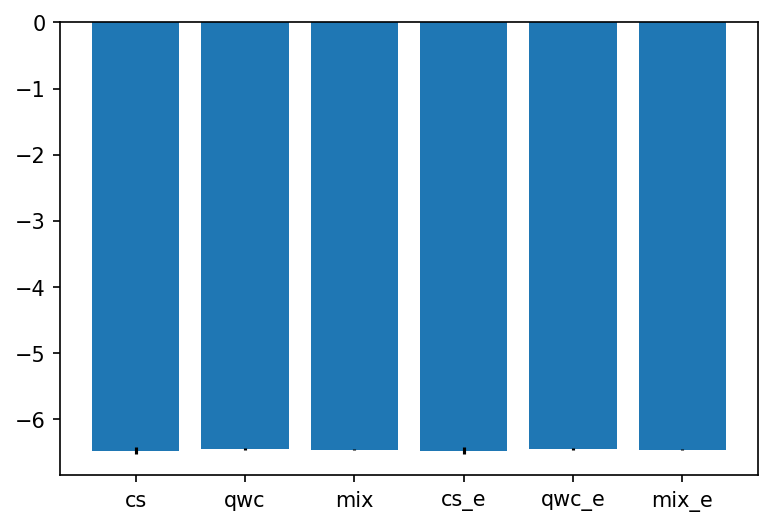

[ 1.00000000e+00+0.j  1.87559429e+00+0.j  6.26703583e+00+0.j
  1.28845254e+01+0.j  6.71820126e+01+0.j  2.50805894e+01+0.j
  1.14688301e+03+0.j -3.30035262e+03+0.j  3.28286499e+04+0.j
 -1.74739571e+05+0.j]


IndexError: index 10 is out of bounds for axis 0 with size 10

In [38]:
# moment data analysis
for i in range(2*K):
    cs_moments = [complex(s) for s in data["cs_moments"][i]]
    qwc_moments = [complex(s) for s in data["qwc_moments"][i]]
    mix_moments = [complex(s) for s in data["mix_moments"][i]]
    plt.bar(["cs","qwc","mix"],[np.mean(cs_moments), np.mean(qwc_moments), np.mean(mix_moments)], 
           yerr = [np.std(cs_moments), np.std(qwc_moments), np.std(mix_moments)])
    print([i, np.std(cs_moments), np.mean(qwc_moments), np.mean(mix_moments)])
    plt.show()
cs_moments = np.array([[complex(s) for s in data["cs_moments"][i]] for i in range(2*K)])
qwc_moments = np.array([[complex(s) for s in data["qwc_moments"][i]] for i in range(2*K)])
mix_moments = np.array([[complex(s) for s in data["mix_moments"][i]] for i in range(2*K)])
for i in range(6):
    cs_e = []
    qwc_e = []
    mix_e = []
    for n_ in range(n_points):
        print(cs_moments[:,n_])
        cs_e += [comp_energy(cs_moments[:,n_], i+1)]
        qwc_e += [comp_energy(qwc_moments[:,n_], i+1)]
        mix_e += [comp_energy(mix_moments[:,n_], i+1)]
    cs_energy = [complex(s) for s in data_no_outliers["cs_energy"][i]]
    qwc_energy = [complex(s) for s in data_no_outliers["qwc_energy"][i]]
    mix_energy = [complex(s) for s in data_no_outliers["mix_energy"][i]]
    plt.bar(["cs","qwc","mix", "cs_e", "qwc_e", "mix_e"],[np.mean(cs_energy), np.mean(qwc_energy), np.mean(mix_energy), np.mean(cs_e), np.mean(qwc_e), np.mean(mix_e)], 
           yerr = [np.std(cs_energy), np.std(qwc_energy), np.std(mix_energy), np.std(cs_e), np.std(qwc_e), np.std(mix_e)])
    plt.show()